<a href="https://colab.research.google.com/github/mtsdrury/fashion-image-classifier/blob/main/notebooks/colab_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Image Classifier: Colab Experiment Notebook

**Research question:** How much does transfer learning improve over a from-scratch CNN for fashion product classification, and which pretrained backbone performs best?

**Models:** SimpleCNN (from scratch), ResNet-50 (pretrained), EfficientNet-B0 (pretrained)

**Dataset:** [Fashion Product Images (Small)](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) -- ~25k product images across multiple categories

**Tracking:** Weights & Biases for experiment logging and comparison

In [2]:
# Verify GPU is available (Runtime > Change runtime type > T4 GPU)
import torch

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU detected. Training will be very slow.")
    print("Go to Runtime > Change runtime type > T4 GPU")

GPU: Tesla T4
Memory: 15.6 GB


In [3]:
!pip install -q wandb

import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mtsdrury (mtsdrury-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Download Dataset

Upload your `kaggle.json` API key file, or use the Google Drive alternative if you have already downloaded the dataset.

In [4]:
import os
import shutil
from google.colab import files

# --- Option 1: Kaggle API (recommended) ---
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
print("Upload your kaggle.json file:")
uploaded = files.upload()
for fn in uploaded:
    shutil.move(fn, os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!mkdir -p /content/data/raw
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -p /content/data/raw --unzip

# --- Option 2: Google Drive (uncomment if dataset is in your Drive) ---
# from google.colab import drive
# drive.mount("/content/drive")
# !cp -r "/content/drive/MyDrive/fashion-product-images-small/" /content/data/raw/

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 96% 541M/565M [00:03<00:00, 83.0MB/s]
100% 565M/565M [00:03<00:00, 163MB/s] 


## Setup: Imports and Configuration

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    top_k_accuracy_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [6]:
# ── Paths (Colab) ─────────────────────────────────────────────────────
DATA_DIR = Path("/content/data/raw")
STYLES_CSV = DATA_DIR / "styles.csv"
RESULTS_DIR = Path("/content/results")
FIGURES_DIR = RESULTS_DIR / "figures"

# Auto-detect image directory (dataset structure varies)
if (DATA_DIR / "images" / "images").is_dir():
    IMAGES_DIR = DATA_DIR / "images" / "images"
elif (DATA_DIR / "images").is_dir():
    IMAGES_DIR = DATA_DIR / "images"
else:
    raise FileNotFoundError(f"No images directory found in {DATA_DIR}. Check download.")

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ── Dataset constants ──────────────────────────────────────────────────
IMAGE_SIZE = 224
MIN_CATEGORY_COUNT = 500

# ── Train / val / test fractions ───────────────────────────────────────
TRAIN_FRAC = 0.7
VAL_FRAC = 0.15
TEST_FRAC = 0.15

# ── ImageNet normalization ─────────────────────────────────────────────
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ── Default hyperparameters ────────────────────────────────────────────
DEFAULT_LR = 1e-3
DEFAULT_BATCH_SIZE = 32
DEFAULT_EPOCHS = 10
DEFAULT_DROPOUT = 0.3
DEFAULT_NUM_WORKERS = 2

# ── W&B ────────────────────────────────────────────────────────────────
WANDB_PROJECT = "fashion-image-classifier"
WANDB_ENTITY = None

# ── Random seed ────────────────────────────────────────────────────────
SEED = 42

# ── Training config ───────────────────────────────────────────────────
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Training for {NUM_EPOCHS} epochs per model")

# ── Verify data exists ────────────────────────────────────────────────
assert STYLES_CSV.exists(), f"styles.csv not found at {STYLES_CSV}"
assert IMAGES_DIR.exists(), f"Images directory not found at {IMAGES_DIR}"
print(f"Data directory: {DATA_DIR}")
print(f"Images directory: {IMAGES_DIR}")

Using device: cuda
Training for 10 epochs per model
Data directory: /content/data/raw
Images directory: /content/data/raw/images


In [7]:
# ── Augmentation and normalization pipelines ──────────────────────────

def get_train_transforms(flip=True, rotation=15.0, color_jitter=True):
    """Build training transform pipeline with configurable augmentation."""
    steps = [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))]
    if flip:
        steps.append(transforms.RandomHorizontalFlip())
    if rotation > 0:
        steps.append(transforms.RandomRotation(rotation))
    if color_jitter:
        steps.append(
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        )
    steps += [
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
    return transforms.Compose(steps)


def get_eval_transforms():
    """Resize and normalize only (no augmentation)."""
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

In [8]:
# ── Data loading: metadata, filtering, splitting, DataLoaders ─────────

def load_metadata(csv_path=STYLES_CSV):
    """Load styles.csv and return a DataFrame with id and articleType."""
    df = pd.read_csv(csv_path, on_bad_lines="skip")
    df = df[["id", "articleType"]].dropna()
    df["id"] = df["id"].astype(int)
    return df


def filter_top_categories(df, min_count=MIN_CATEGORY_COUNT):
    """Keep only categories with at least min_count images."""
    counts = df["articleType"].value_counts()
    keep = counts[counts >= min_count].index
    return df[df["articleType"].isin(keep)].reset_index(drop=True)


def verify_images_exist(df, images_dir=IMAGES_DIR):
    """Drop rows whose image file is missing on disk."""
    exists_mask = df["id"].apply(
        lambda pid: (images_dir / f"{pid}.jpg").is_file()
    )
    return df[exists_mask].reset_index(drop=True)


def encode_labels(df):
    """Add an integer label column; return label-to-index and index-to-label maps."""
    categories = sorted(df["articleType"].unique())
    label_to_idx = {cat: i for i, cat in enumerate(categories)}
    idx_to_label = {i: cat for cat, i in label_to_idx.items()}
    df = df.copy()
    df["label"] = df["articleType"].map(label_to_idx)
    return df, label_to_idx, idx_to_label


def split_data(df, train_frac=TRAIN_FRAC, val_frac=VAL_FRAC,
               test_frac=TEST_FRAC, seed=SEED):
    """Stratified split into train, validation, and test sets."""
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
    train_df, temp_df = train_test_split(
        df, test_size=(val_frac + test_frac),
        stratify=df["label"], random_state=seed,
    )
    relative_test = test_frac / (val_frac + test_frac)
    val_df, test_df = train_test_split(
        temp_df, test_size=relative_test,
        stratify=temp_df["label"], random_state=seed,
    )
    return (
        train_df.reset_index(drop=True),
        val_df.reset_index(drop=True),
        test_df.reset_index(drop=True),
    )


class FashionDataset(Dataset):
    """Map-style dataset that loads product images and returns (image, label)."""

    def __init__(self, df, images_dir=IMAGES_DIR, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.images_dir / f"{row['id']}.jpg"
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, int(row["label"])


def build_dataloaders(train_df, val_df, test_df, images_dir=IMAGES_DIR,
                      batch_size=DEFAULT_BATCH_SIZE, num_workers=DEFAULT_NUM_WORKERS,
                      augment_flip=True, augment_rotation=15.0,
                      augment_color_jitter=True):
    """Create train, validation, and test DataLoaders."""
    train_transform = get_train_transforms(
        flip=augment_flip, rotation=augment_rotation, color_jitter=augment_color_jitter,
    )
    eval_transform = get_eval_transforms()

    train_ds = FashionDataset(train_df, images_dir, transform=train_transform)
    val_ds = FashionDataset(val_df, images_dir, transform=eval_transform)
    test_ds = FashionDataset(test_df, images_dir, transform=eval_transform)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    )
    return train_loader, val_loader, test_loader

In [9]:
# ── Model definitions: SimpleCNN, ResNet-50, EfficientNet-B0 ──────────

class SimpleCNN(nn.Module):
    """3-block CNN trained from scratch."""

    def __init__(self, num_classes, dropout=DEFAULT_DROPOUT):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


class ResNet50Classifier(nn.Module):
    """ResNet-50 with pretrained ImageNet backbone and replaced FC head."""

    def __init__(self, num_classes, dropout=DEFAULT_DROPOUT, pretrained=True):
        super().__init__()
        weights = models.ResNet50_Weights.DEFAULT if pretrained else None
        self.backbone = models.resnet50(weights=weights)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)


class EfficientNetB0Classifier(nn.Module):
    """EfficientNet-B0 with pretrained ImageNet backbone and replaced classifier."""

    def __init__(self, num_classes, dropout=DEFAULT_DROPOUT, pretrained=True):
        super().__init__()
        weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        self.backbone = models.efficientnet_b0(weights=weights)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)


MODEL_REGISTRY = {
    "simple_cnn": SimpleCNN,
    "resnet50": ResNet50Classifier,
    "efficientnet_b0": EfficientNetB0Classifier,
}


def build_model(name, num_classes, **kwargs):
    """Instantiate a model by registry name."""
    if name not in MODEL_REGISTRY:
        raise ValueError(
            f"Unknown model '{name}'. Choose from: {list(MODEL_REGISTRY.keys())}"
        )
    # SimpleCNN doesn't accept 'pretrained', so drop it
    if name == "simple_cnn":
        kwargs.pop("pretrained", None)
    return MODEL_REGISTRY[name](num_classes=num_classes, **kwargs)

In [10]:
# ── Pure evaluation functions ─────────────────────────────────────────

def compute_accuracy(y_true, y_pred):
    """Overall accuracy."""
    return float(accuracy_score(y_true, y_pred))


def compute_classification_report(y_true, y_pred, label_names=None):
    """Per-class precision, recall, F1 as a dict."""
    return classification_report(
        y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0
    )


def compute_confusion_matrix(y_true, y_pred):
    """Confusion matrix as a 2-D numpy array."""
    return confusion_matrix(y_true, y_pred)


def compute_topk_accuracy(y_true, y_probs, k=3):
    """Top-k accuracy from probability matrix."""
    labels = list(range(y_probs.shape[1]))
    return float(top_k_accuracy_score(y_true, y_probs, k=k, labels=labels))

In [11]:
# ── W&B helper functions ──────────────────────────────────────────────

def _denormalize(tensor):
    """Convert a normalized image tensor back to uint8 HWC numpy array for display."""
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    img = tensor.cpu() * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    return (img * 255).astype(np.uint8)


def init_wandb_run(config, project, entity=None, **kwargs):
    """Initialize a W&B run. Returns the run object."""
    return wandb.init(project=project, entity=entity, config=config, **kwargs)


def log_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Log a confusion matrix to the current W&B run."""
    wandb.log(
        {
            title: wandb.plot.confusion_matrix(
                probs=None, y_true=y_true, preds=y_pred, class_names=class_names
            )
        }
    )


def log_sample_predictions(images, y_true, y_pred, confidences, class_names,
                           max_images=16):
    """Log a grid of sample predictions (correct and incorrect) to W&B."""
    table = wandb.Table(columns=["image", "true", "predicted", "confidence", "correct"])
    n = min(len(y_true), max_images)
    for i in range(n):
        img_array = _denormalize(images[i])
        table.add_data(
            wandb.Image(img_array),
            class_names[y_true[i]],
            class_names[y_pred[i]],
            f"{confidences[i]:.3f}",
            y_true[i] == y_pred[i],
        )
    wandb.log({"sample_predictions": table})

In [12]:
# ── Training and evaluation loops ─────────────────────────────────────

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Run one training epoch. Returns (avg_loss, accuracy)."""
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(all_labels)
    accuracy = compute_accuracy(all_labels, all_preds)
    return avg_loss, accuracy


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate model on a data loader. Returns (avg_loss, accuracy, y_true, y_pred)."""
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(all_labels)
    accuracy = compute_accuracy(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds


def train_model(model, train_loader, val_loader, num_epochs=DEFAULT_EPOCHS,
                lr=DEFAULT_LR, device=None, use_wandb=False, class_names=None):
    """Full training pipeline with optional W&B logging.

    Returns a dict with final train/val loss and accuracy.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, val_true, val_pred = evaluate(
            model, val_loader, criterion, device
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"  Epoch {epoch + 1}/{num_epochs} | "
              f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} | "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

        if use_wandb:
            wandb.log(
                {
                    "epoch": epoch + 1,
                    "train/loss": train_loss,
                    "train/accuracy": train_acc,
                    "val/loss": val_loss,
                    "val/accuracy": val_acc,
                }
            )

    # Log final confusion matrix
    if use_wandb and class_names:
        log_confusion_matrix(val_true, val_pred, class_names, title="val/confusion_matrix")

    return {
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "best_val_accuracy": best_val_acc,
    }

## 1. Data Exploration

In [13]:
# Load and filter metadata
df = load_metadata(STYLES_CSV)
print(f"Total rows in styles.csv: {len(df)}")
print(f"Unique article types: {df['articleType'].nunique()}")

df = filter_top_categories(df)
print(f"\nAfter filtering (>= 500 images): {len(df)} rows, {df['articleType'].nunique()} categories")

df = verify_images_exist(df, IMAGES_DIR)
print(f"After verifying images exist: {len(df)} rows")

Total rows in styles.csv: 44424
Unique article types: 143

After filtering (>= 500 images): 34723 rows, 23 categories
After verifying images exist: 34719 rows


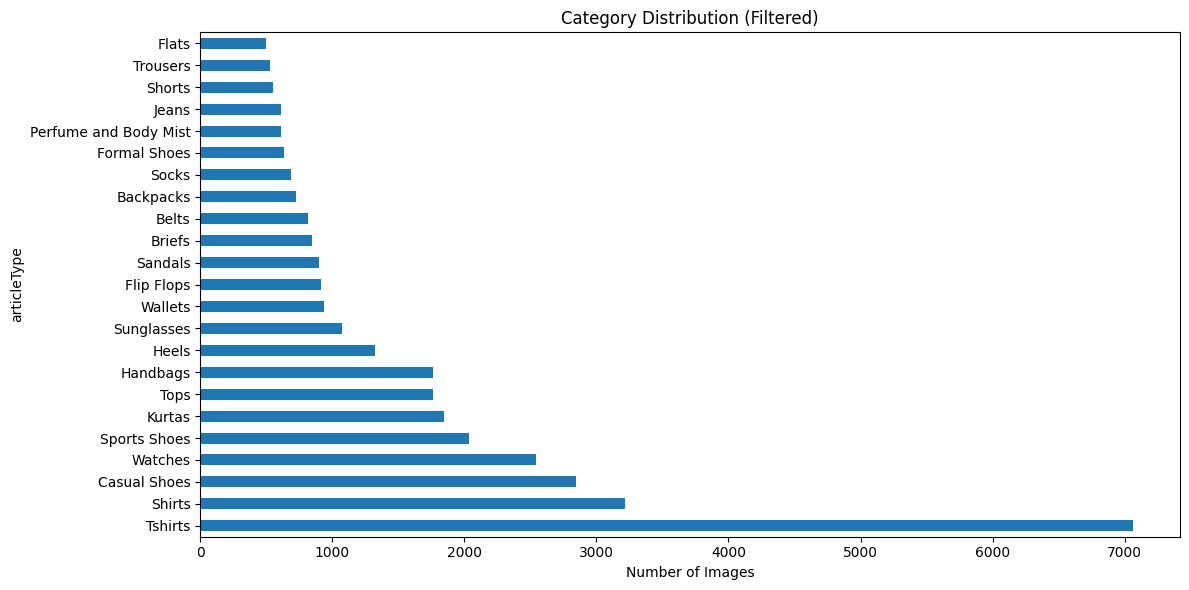

In [14]:
# Category distribution
fig, ax = plt.subplots(figsize=(12, 6))
counts = df["articleType"].value_counts()
counts.plot(kind="barh", ax=ax)
ax.set_xlabel("Number of Images")
ax.set_title("Category Distribution (Filtered)")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "category_distribution.png", dpi=150)
plt.show()

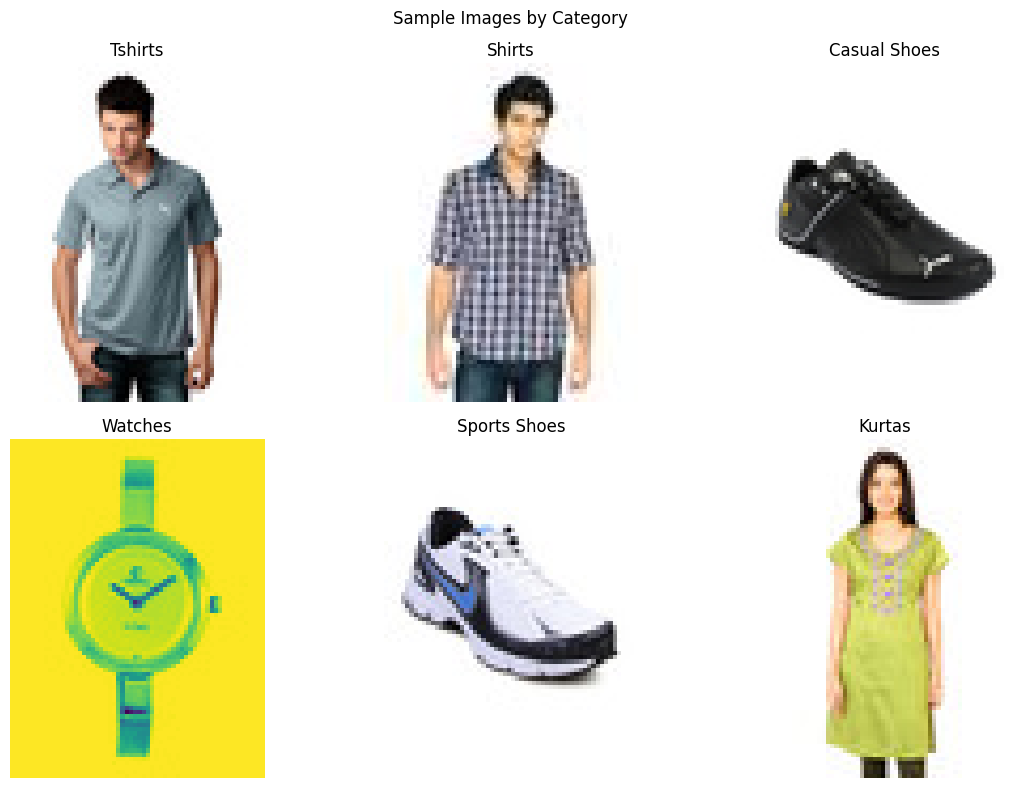

In [15]:
# Sample images
sample_cats = counts.head(6).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, cat in zip(axes.flat, sample_cats):
    sample_id = df[df["articleType"] == cat].iloc[0]["id"]
    img = Image.open(IMAGES_DIR / f"{sample_id}.jpg")
    ax.imshow(img)
    ax.set_title(cat)
    ax.axis("off")
plt.suptitle("Sample Images by Category")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "sample_images.png", dpi=150)
plt.show()

## 2. Data Preparation

In [16]:
df, label_to_idx, idx_to_label = encode_labels(df)
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

train_df, val_df, test_df = split_data(df)
print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Number of classes: 23
Class names: ['Backpacks', 'Belts', 'Briefs', 'Casual Shoes', 'Flats', 'Flip Flops', 'Formal Shoes', 'Handbags', 'Heels', 'Jeans', 'Kurtas', 'Perfume and Body Mist', 'Sandals', 'Shirts', 'Shorts', 'Socks', 'Sports Shoes', 'Sunglasses', 'Tops', 'Trousers', 'Tshirts', 'Wallets', 'Watches']

Train: 24303, Val: 5208, Test: 5208


In [17]:
train_loader, val_loader, test_loader = build_dataloaders(
    train_df, val_df, test_df,
    images_dir=IMAGES_DIR,
    batch_size=DEFAULT_BATCH_SIZE,
    num_workers=2,
)

## 3. Train All Three Models

Each model gets its own W&B run for comparison.

In [ ]:
all_results = {}
trained_models = {}

model_configs = [
    {"name": "simple_cnn", "pretrained": False, "lr": 1e-3, "epochs": NUM_EPOCHS},
    {"name": "resnet50", "pretrained": True, "lr": 1e-4, "epochs": NUM_EPOCHS},
    {"name": "efficientnet_b0", "pretrained": True, "lr": 1e-4, "epochs": NUM_EPOCHS},
]

for cfg in model_configs:
    print(f"\n{'='*60}")
    print(f"Training: {cfg['name']}")
    print(f"{'='*60}")

    run = init_wandb_run(
        config={
            "model_name": cfg["name"],
            "learning_rate": cfg["lr"],
            "batch_size": DEFAULT_BATCH_SIZE,
            "dropout": DEFAULT_DROPOUT,
            "epochs": cfg["epochs"],
            "num_classes": num_classes,
        },
        project=WANDB_PROJECT,
        name=f"{cfg['name']}_baseline",
    )

    model = build_model(
        cfg["name"],
        num_classes=num_classes,
        dropout=DEFAULT_DROPOUT,
        pretrained=cfg.get("pretrained", False),
    )

    results = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=cfg["epochs"],
        lr=cfg["lr"],
        device=device,
        use_wandb=True,
        class_names=class_names,
    )

    all_results[cfg["name"]] = results
    trained_models[cfg["name"]] = model
    print(f"Best val accuracy: {results['best_val_accuracy']:.4f}")
    wandb.finish()

print("\nAll training complete.")


Training: simple_cnn


  Epoch 1/10 | train_loss: 2.2838, train_acc: 0.3116 | val_loss: 1.9622, val_acc: 0.4017
  Epoch 2/10 | train_loss: 1.9013, train_acc: 0.4054 | val_loss: 2.4956, val_acc: 0.2776
  Epoch 3/10 | train_loss: 1.7138, train_acc: 0.4564 | val_loss: 8.1277, val_acc: 0.1584
  Epoch 4/10 | train_loss: 1.5813, train_acc: 0.4929 | val_loss: 1.3697, val_acc: 0.5902
  Epoch 5/10 | train_loss: 1.4881, train_acc: 0.5206 | val_loss: 1.6226, val_acc: 0.4806
  Epoch 6/10 | train_loss: 1.4139, train_acc: 0.5416 | val_loss: 1.6931, val_acc: 0.4666
  Epoch 7/10 | train_loss: 1.3438, train_acc: 0.5559 | val_loss: 1.1645, val_acc: 0.6212
  Epoch 8/10 | train_loss: 1.2859, train_acc: 0.5765 | val_loss: 1.2147, val_acc: 0.5981
  Epoch 9/10 | train_loss: 1.2466, train_acc: 0.5877 | val_loss: 1.3296, val_acc: 0.5685
  Epoch 10/10 | train_loss: 1.1889, train_acc: 0.6059 | val_loss: 0.9634, val_acc: 0.6909
Best val accuracy: 0.6909


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▃▄▅▆▆▇▇██
train/loss,█▆▄▄▃▂▂▂▁▁
val/accuracy,▄▃▁▇▅▅▇▇▆█
val/loss,▂▂█▁▂▂▁▁▁▁
epoch,10
train/accuracy,0.60589
train/loss,1.18889
val/accuracy,0.69086
val/loss,0.96341



Training: resnet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


  Epoch 1/10 | train_loss: 0.5762, train_acc: 0.8170 | val_loss: 0.2466, val_acc: 0.9099
  Epoch 2/10 | train_loss: 0.2489, train_acc: 0.9110 | val_loss: 0.2164, val_acc: 0.9184
  Epoch 3/10 | train_loss: 0.2003, train_acc: 0.9269 | val_loss: 0.2285, val_acc: 0.9151
  Epoch 4/10 | train_loss: 0.1675, train_acc: 0.9378 | val_loss: 0.1996, val_acc: 0.9245
  Epoch 5/10 | train_loss: 0.1425, train_acc: 0.9459 | val_loss: 0.1873, val_acc: 0.9332
  Epoch 6/10 | train_loss: 0.1311, train_acc: 0.9507 | val_loss: 0.2003, val_acc: 0.9326
  Epoch 7/10 | train_loss: 0.1126, train_acc: 0.9575 | val_loss: 0.2150, val_acc: 0.9315
  Epoch 8/10 | train_loss: 0.0975, train_acc: 0.9637 | val_loss: 0.2422, val_acc: 0.9267
  Epoch 9/10 | train_loss: 0.0840, train_acc: 0.9693 | val_loss: 0.2402, val_acc: 0.9209
  Epoch 10/10 | train_loss: 0.0735, train_acc: 0.9735 | val_loss: 0.2456, val_acc: 0.9265
Best val accuracy: 0.9332


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▆▆▇▇▇███
train/loss,█▃▃▂▂▂▂▁▁▁
val/accuracy,▁▄▃▅██▇▆▄▆
val/loss,█▄▆▂▁▃▄▇▇█
epoch,10
train/accuracy,0.9735
train/loss,0.07348
val/accuracy,0.92646
val/loss,0.24565



Training: efficientnet_b0


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 187MB/s]


  Epoch 1/10 | train_loss: 0.7118, train_acc: 0.7922 | val_loss: 0.2539, val_acc: 0.9094
  Epoch 2/10 | train_loss: 0.2887, train_acc: 0.9005 | val_loss: 0.2162, val_acc: 0.9194
  Epoch 3/10 | train_loss: 0.2273, train_acc: 0.9187 | val_loss: 0.2067, val_acc: 0.9259
  Epoch 4/10 | train_loss: 0.1981, train_acc: 0.9277 | val_loss: 0.1904, val_acc: 0.9311
  Epoch 5/10 | train_loss: 0.1752, train_acc: 0.9357 | val_loss: 0.1850, val_acc: 0.9290
  Epoch 6/10 | train_loss: 0.1547, train_acc: 0.9437 | val_loss: 0.2003, val_acc: 0.9288
  Epoch 7/10 | train_loss: 0.1366, train_acc: 0.9491 | val_loss: 0.1886, val_acc: 0.9328
  Epoch 8/10 | train_loss: 0.1187, train_acc: 0.9558 | val_loss: 0.2016, val_acc: 0.9313
  Epoch 9/10 | train_loss: 0.1092, train_acc: 0.9585 | val_loss: 0.1970, val_acc: 0.9343


## 4. Model Comparison

In [ ]:
# Comparison table
comparison = pd.DataFrame(all_results).T
comparison.index.name = "Model"
print(comparison.to_markdown())

In [ ]:
# Bar chart of validation accuracy
fig, ax = plt.subplots(figsize=(8, 5))
model_names = list(all_results.keys())
val_accs = [all_results[m]["best_val_accuracy"] for m in model_names]
ax.bar(model_names, val_accs)
ax.set_ylabel("Best Validation Accuracy")
ax.set_title("Model Comparison: Validation Accuracy")
ax.set_ylim(0, 1)
for i, v in enumerate(val_accs):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "model_comparison.png", dpi=150)
plt.show()

## 5. Test Set Evaluation (Best Model)

In [ ]:
# Use already-trained best model for test evaluation (no retrain)
best_model_name = max(all_results, key=lambda m: all_results[m]["best_val_accuracy"])
print(f"Best model: {best_model_name}")

best_model = trained_models[best_model_name]

# Test set evaluation
criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc, y_true, y_pred = evaluate(best_model, test_loader, criterion, device)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

In [ ]:
# Classification report
report = compute_classification_report(y_true, y_pred, label_names=class_names)
report_df = pd.DataFrame(report).T
print(report_df.to_markdown())

In [ ]:
# Confusion matrix heatmap
cm = compute_confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix: {best_model_name}")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "confusion_matrix.png", dpi=150)
plt.show()

## 6. Error Analysis

Which class pairs are most commonly confused?

In [ ]:
# Find most confused pairs (off-diagonal elements)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)

# Top 5 confused pairs
confused_pairs = []
for _ in range(5):
    i, j = np.unravel_index(cm_copy.argmax(), cm_copy.shape)
    confused_pairs.append((class_names[i], class_names[j], cm_copy[i, j]))
    cm_copy[i, j] = 0

print("Most confused pairs:")
for true_cls, pred_cls, count in confused_pairs:
    print(f"  {true_cls} -> {pred_cls}: {count} misclassifications")

## 7. Hyperparameter Sweep Results

After running `wandb sweep sweep.yaml` and `wandb agent <sweep-id>`, pull results via the W&B API.

In [ ]:
# Pull sweep results from W&B API (skip if no sweep runs yet)
try:
    api = wandb.Api()
    runs = api.runs(WANDB_PROJECT)

    sweep_data = []
    for run in runs:
        if run.state == "finished":
            sweep_data.append({
                "name": run.name,
                "model": run.config.get("model_name", "unknown"),
                "lr": run.config.get("learning_rate"),
                "batch_size": run.config.get("batch_size"),
                "dropout": run.config.get("dropout"),
                "val_accuracy": run.summary.get("val/accuracy"),
            })

    sweep_df = pd.DataFrame(sweep_data)
    print(f"Total finished runs: {len(sweep_df)}")
    if len(sweep_df) > 0:
        print(sweep_df.sort_values("val_accuracy", ascending=False).head(10).to_markdown())
    else:
        print("No sweep runs found yet. Run wandb sweep + wandb agent to populate.")
except Exception as e:
    print(f"Could not fetch sweep results: {e}")
    sweep_df = pd.DataFrame()

In [ ]:
# Best config per model
if len(sweep_df) > 0:
    best_per_model = sweep_df.loc[sweep_df.groupby("model")["val_accuracy"].idxmax()]
    print(best_per_model[["model", "lr", "batch_size", "dropout", "val_accuracy"]].to_markdown())

## 8. Conclusions

**Research question:** How much does transfer learning improve over a from-scratch CNN, and which backbone performs best?

*Fill in after runs complete:*

- SimpleCNN (from scratch): __% validation accuracy
- ResNet-50 (pretrained): __% validation accuracy
- EfficientNet-B0 (pretrained): __% validation accuracy

**Key findings:**
- Transfer learning provides a ___ percentage point improvement over training from scratch.
- [Best model] achieves the highest accuracy while [comparison notes].
- The most commonly confused categories are [X] and [Y], which makes sense because [reason].
- Hyperparameter sweep found that [key insights about learning rate, batch size, etc.].